# Plot reaction yields

We want to plot the yields of the 50k reactions (or conceivably, only the ones that are not invalid).
We may want to use logarithmic bins or just reaction outcome instead of yield.
We want a meaningful 2D representation, ideally some kind of grid.


An easy approach to realize that would be to look at 2 of 3 dimensions at a time and average over the third

In [1]:
import pathlib
import sys
sys.path.append(str(pathlib.Path().resolve().parent.parent))

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import sompy

from src.util.db_utils import MyDatabaseConnection

In [2]:
con = MyDatabaseConnection()
experiments = con.execute_arbitrary_simple_query("SELECT * FROM experiments WHERE exp_nr BETWEEN 4 AND 29")
len(experiments)

49920

In [3]:
experiments[0]

(10578,
 5,
 4,
 'A3',
 'JG255',
 '2021-08-17',
 'I67',
 'M20',
 'T25',
 'Ph023',
 'Mon017',
 'TerTH010',
 'Ph023 + Mon017 + TerTH010',
 0.37324885530898905,
 0.273657636613575,
 0.00852549327655528,
 0.0,
 0.0703915205010801,
 0.06669939673319483,
 0.1533810158723596,
 0.006903287821314509,
 None,
 'CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(C=Cc2ccccc2)s1)NC(=O)c1ccc(Cl)cc1',
 'CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(C=Cc2ccccc2)S1)NC(=O)c1ccc(Cl)cc1',
 'CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(C=Cc3ccccc3)=N[N+]2=C(c2ccc(Cl)cc2)N1',
 'Clc1ccc(-c2nnc(C=Cc3ccccc3)s2)cc1',
 'C(=Cc1nnc(C=Cc2ccccc2)s1)c1ccccc1',
 'CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1ccc(Cl)cc1',
 'CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1',
 'CC(C)(C)OC(=O)CCC=Cc1nnc(C=Cc2ccccc2)s1',
 201048,
 'WARNING: heating failure on first step; WARNING: multiple peaks for product A (2)')

In [4]:
# get headers from SQLite DB
columns = [i[0] for i in con.execute_arbitrary_simple_query("SELECT name FROM PRAGMA_TABLE_INFO('experiments')")]
columns

['id',
 'exp_nr',
 'plate_nr',
 'well',
 'lab_journal_number',
 'synthesis_date_unixepoch',
 'initiator',
 'monomer',
 'terminator',
 'initiator_long',
 'monomer_long',
 'terminator_long',
 'long_name',
 'product_A_lcms_ratio',
 'product_B_lcms_ratio',
 'product_C_lcms_ratio',
 'product_D_lcms_ratio',
 'product_E_lcms_ratio',
 'product_F_lcms_ratio',
 'product_G_lcms_ratio',
 'product_H_lcms_ratio',
 'comment',
 'product_A_smiles',
 'product_B_smiles',
 'product_C_smiles',
 'product_D_smiles',
 'product_E_smiles',
 'product_F_smiles',
 'product_G_smiles',
 'product_H_smiles',
 'vl_id',
 'valid']

In [5]:
# make a dataframe
df = pd.DataFrame(experiments, columns=columns)
df.head(3)

,id,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
0,10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(C=Cc2ccccc2)s1)N...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(C=Cc2cc...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(C=Cc3cc...,Clc1ccc(-c2nnc(C=Cc3ccccc3)s2)cc1,C(=Cc1nnc(C=Cc2ccccc2)s1)c1ccccc1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(C=Cc2ccccc2)s1,201048,WARNING: heating failure on first step; WARNIN...
1,10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cn[nH]c2)s1)N...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2cn[nH...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3cn[nH...,Clc1ccc(-c2nnc(-c3cn[nH]c3)s2)cc1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2cn[nH]c2)s1,201062,WARNING: heating failure on first step; WARNIN...
2,10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cc(Cl)cc(Cl)c...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2cc(Cl...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3cc(Cl...,Clc1ccc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)cc1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2cc(Cl)cc(Cl)c2)s1,201053,WARNING: heating failure on first step; WARNIN...


In [6]:
df.iloc[0]

id                                                                      10578
exp_nr                                                                      5
plate_nr                                                                    4
well                                                                       A3
lab_journal_number                                                      JG255
synthesis_date_unixepoch                                           2021-08-17
initiator                                                                 I67
monomer                                                                   M20
terminator                                                                T25
initiator_long                                                          Ph023
monomer_long                                                           Mon017
terminator_long                                                      TerTH010
long_name                                           Ph023 + Mon0

In [7]:
# get the building block identities from DB
building_blocks = con.execute_arbitrary_simple_query("SELECT * FROM buildingblocks")
len(building_blocks)

193

In [8]:
building_blocks[0]

(3,
 '2-Pyr002',
 'I1',
 'O=C(c1cc(Cl)ccn1)[B-](F)(F)F.[K+]',
 '/Users/julian/PycharmProjects/library-generation/data/db/static/image/I1.png',
 'I',
 0,
 0,
 0,
 0,
 207.99538003591,
 None,
 None,
 None,
 'C6H3BClF3NO-',
 None,
 'KAT_hetarom')

In [ ]:
# get reaction outcome

In [9]:
# get ECFP4 for all building blocks using RDKit
ecfp4 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i[3]), 4, nBits=512) for i in building_blocks]
# convert to numpy array
ecfp4 = [np.array(i) for i in ecfp4]


In [10]:
# build dictionary from building block short name to ECFP4
bb_dict = {bb[2]: ecfp4[i] for i, bb in enumerate(building_blocks)}
bb_dict.keys()

dict_keys(['I1', 'I2', 'I53', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I50', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I48', 'I41', 'I75', 'I43', 'I44', 'I45', 'I46', 'I47', 'I40', 'I49', 'I16', 'I51', 'I52', 'I3', 'I54', 'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I62', 'I61', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I42', 'I76', 'I77', 'I78', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23', 'M24', 'M25', 'M26', 'M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'M33', 'M34', 'M35', 'M36', 'M37', 'M38', 'M39', 'M40', 'M41', 'M42', 'M43', 'M44', 'M45', 'M46', 'M47', 'M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M61', 'M60', 'M62', 'M63', 'M64', 'M65', 'M66',

In [11]:
df["initiator_ecfp4"] = df["initiator"].apply(lambda x: bb_dict[x])
df["monomer_ecfp4"] = df["monomer"].apply(lambda x: bb_dict[x])
df["terminator_ecfp4"] = df["terminator"].apply(lambda x: bb_dict[x])
concatenated_ecfp4 = np.concatenate([df["initiator_ecfp4"].values.tolist(), df["monomer_ecfp4"].values.tolist(), df["terminator_ecfp4"].values.tolist()], axis=1)

In [12]:
concatenated_ecfp4.shape

(49920, 1536)

In [13]:
som = sompy.SOMFactory.build(concatenated_ecfp4, (260, 192), mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods

In [14]:
som.train(n_job=32, verbose='info')

 Training...
 pca_linear_initialization took: 2.766000 seconds
 Rough training...
 radius_ini: 33.000000 , radius_final: 8.250000, trainlen: 30

 epoch: 1 ---> elapsed time:  142.066000, quantization error: 33.827732

 epoch: 2 ---> elapsed time:  142.435000, quantization error: 33.270630

 epoch: 3 ---> elapsed time:  143.799000, quantization error: 31.689563

 epoch: 4 ---> elapsed time:  148.882000, quantization error: 31.344348

 epoch: 5 ---> elapsed time:  153.310000, quantization error: 31.147806

 epoch: 6 ---> elapsed time:  143.032000, quantization error: 30.991564

 epoch: 7 ---> elapsed time:  149.610000, quantization error: 30.851015

 epoch: 8 ---> elapsed time:  148.197000, quantization error: 30.709437

 epoch: 9 ---> elapsed time:  147.164000, quantization error: 30.551273

 epoch: 10 ---> elapsed time:  146.653000, quantization error: 30.385251

 epoch: 11 ---> elapsed time:  146.465000, quantization error: 30.223339

 epoch: 12 ---> elapsed time:  146.620000, quantiz

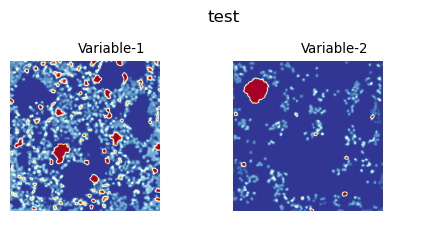

In [15]:


v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
#sompy.mapview.View2DPacked(300, 300, 'test').show(som)
v.show(som, what='codebook', which_dim=[0,1], cmap=None, col_sz=6) #which_dim='all' default
# v.save('2d_packed_test')



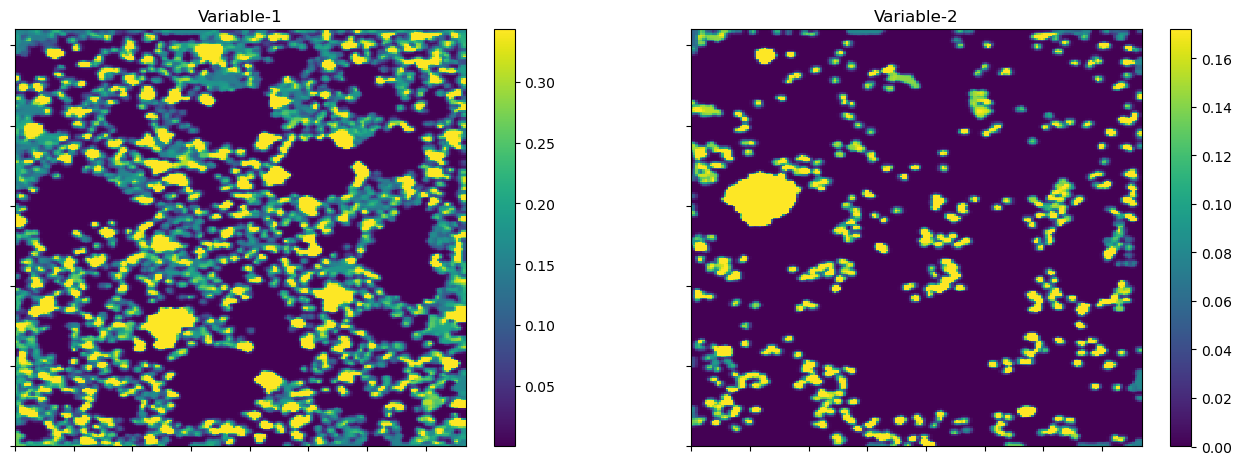

In [23]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim=[0,1], denormalize=True)



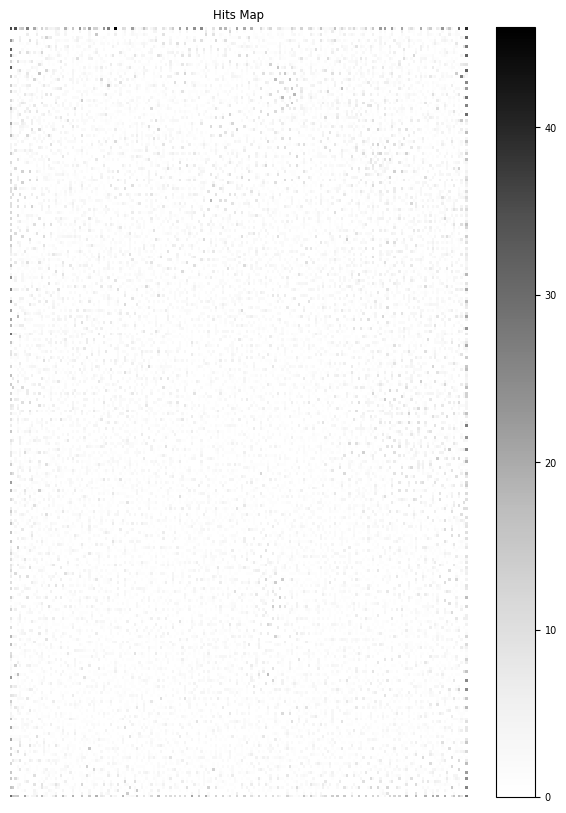

In [26]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7, show_text=False)
vhts.show(som, anotate=False, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

/Users/julian/.pyenv/versions/anaconda3-2020.07/envs/library-generation/lib/python3.9/site-packages/sompy/visualization/umatrix.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, s=2, alpha=1., c='Gray',


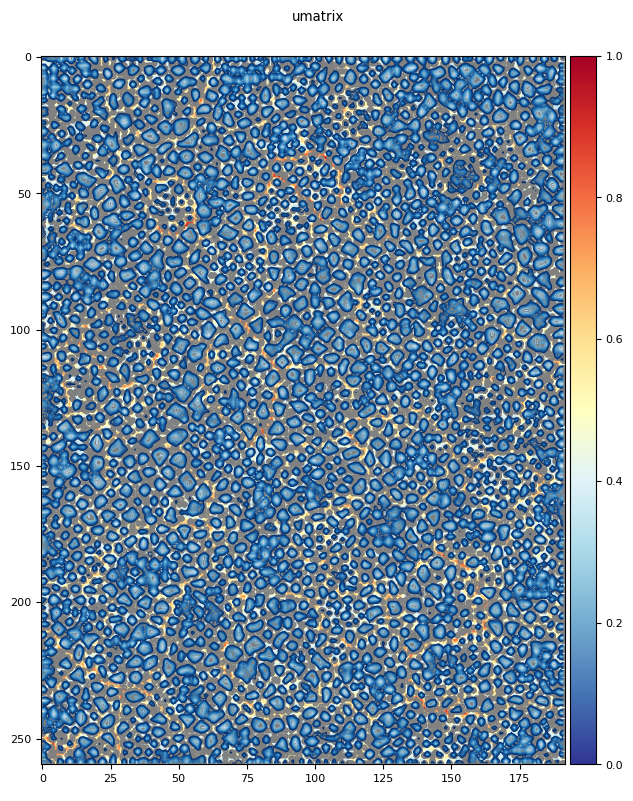

In [ ]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance=1, row_normalized=False, show_data=True, contour=True, blob=False)



In [20]:
help(sompy.dotmap.DotMapView)

Help on class DotMapView in module sompy.visualization.dotmap:

class DotMapView(sompy.visualization.view.MatplotView)
 |  DotMapView(width, height, title, show_axis=True, packed=True, text_size=2.8, show_text=True, col_size=6, *args, **kwargs)
 |  
 |  Method resolution order:
 |      DotMapView
 |      sompy.visualization.view.MatplotView
 |      sompy.visualization.view.View
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  init_figure(self, dim, cols)
 |  
 |  plot(self, data, coords, msz0, msz1, colormap, dlen, dim, rows, cols)
 |  
 |  show(self, som, which_dim='all', colormap=None, cols=None)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from sompy.visualization.view.MatplotView:
 |  
 |  __del__(self)
 |  
 |  __init__(self, width, height, title, show_axis=True, packed=True, text_size=2.8, show_text=True, col_size=6, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  


In [21]:
help(som)

Help on SOM in module sompy.sompy object:

class SOM(builtins.object)
 |  SOM(data, neighborhood, normalizer=None, mapsize=None, mask=None, mapshape='planar', lattice='rect', initialization='pca', training='batch', name='sompy', component_names=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, neighborhood, normalizer=None, mapsize=None, mask=None, mapshape='planar', lattice='rect', initialization='pca', training='batch', name='sompy', component_names=None)
 |      Self Organizing Map
 |      
 |      :param data: data to be clustered, represented as a matrix of n rows,
 |          as inputs and m cols as input features
 |      :param neighborhood: neighborhood object calculator.
 |      :param normalizer: normalizer object calculator.
 |      :param mapsize: tuple/list defining the dimensions of the som. If
 |          single number is provided is considered as the number of nodes.
 |      :param mask: mask
 |      :param mapshape: shape of the som.
 |      :param lat

# Conclusion

I don't understand this package well enough to quickly come up with something useful here.